In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import seaborn as sns

import sc_average_overlap as ao

In [2]:
adata = sc.read_10x_mtx(
    'data/3kpbmc_data/filtered_gene_bc_matrices/hg19/',  
    var_names='gene_symbols',                
    )  

adata.var_names_make_unique()

In [3]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Preprocessing

We start with a very simple preprocessing workflow.

In [4]:
# Filter lowly expressing cells, or genes that aren't expressed in many cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Filter based on mitochondrial expression
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

# Log-normalizaiton
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Simple HVG inference
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\preprocessing\_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### PCA + neighbor graph + UMAP

In [5]:
sc.tl.pca(adata, svd_solver='arpack')

sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50,)

sc.tl.umap(adata)

c:\users\chris\appdata\local\programs\python\python39\lib\site-packages\scanpy\preprocessing\_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm["X_pca"] = X_pca


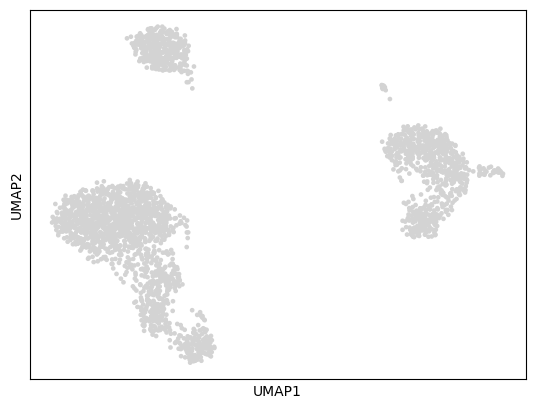

In [6]:
sc.pl.umap(adata)

### Clustering

In [7]:
sc.tl.leiden(adata)

C:\Users\chris\AppData\Local\Temp\ipykernel_10676\3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


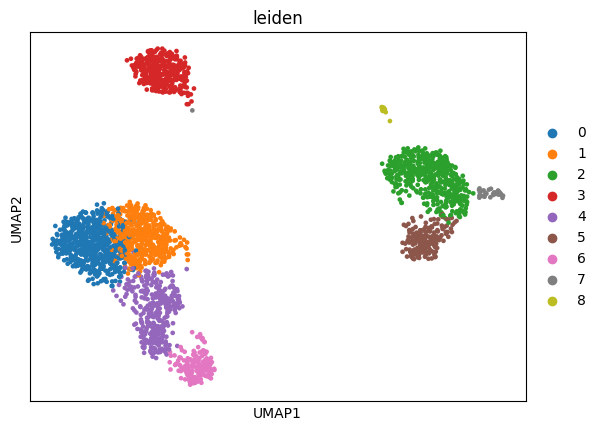

In [8]:
sc.pl.umap(adata, color=['leiden',])

In [9]:
sc.tl.rank_genes_groups(adata, groupby='leiden')

### Constructing the average overlap tree

One can construct an average overlap tree immediately. By default, these scores are calculated based on the top *k* genes in each cluster.

In [10]:
ao.make_ao_dendrogram(adata, groupby='leiden')

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Cluster label', ylabel='AO Distance'>)

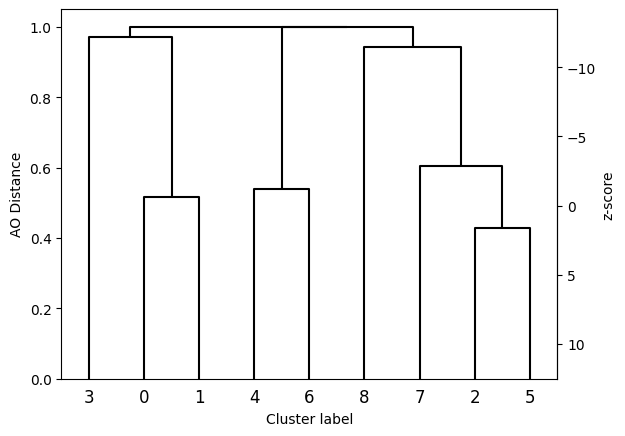

In [11]:
ao.plot_ao_dendrogram(adata, 'leiden')

In our paper, we combined the set of all cluster marker genes, and based the average overlap off of each cluster's rankings of this combined set. We do this because AO of conjoint ranked lists (they contain the same elements, just ranked differently) follows a normal distribution, allowing us to attribute significance to AO scores and have a point of reference.

Here, we use the `get_all_cluster_markers()` function to do exactly that for the Leiden clusters.

In [12]:
marker_set = ao.get_all_cluster_markers(adata, groupby='leiden', n_genes=25)
len(marker_set)

144

In [13]:
ao.make_ao_dendrogram(adata, groupby='leiden', genes_to_filter=marker_set)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Cluster label', ylabel='AO Distance'>)

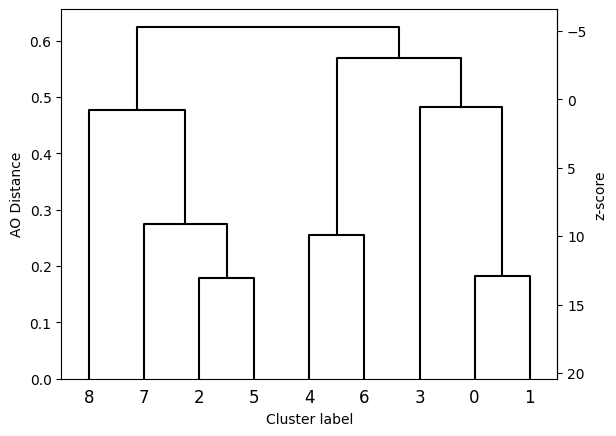

In [14]:
ao.plot_ao_dendrogram(adata, 'leiden')

We can also plot the AO heatmap.

(<Figure size 640x480 with 2 Axes>, <Axes: >)

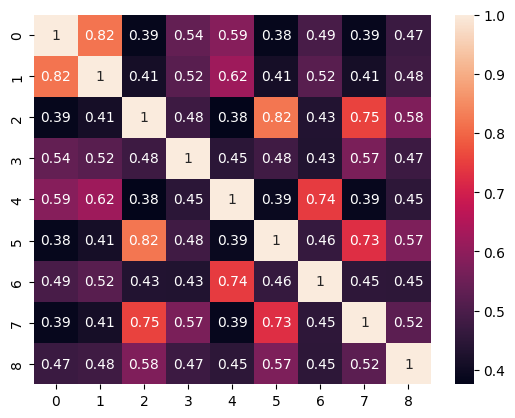

In [15]:
ao.plot_ao_heatmap(adata, 'leiden', plot_zscores=False, annot_decimal_format='.2g')

You can also use the dendrogram's information, which is stored in the `uns` attribute of `adata`. We set it to Scanpy's default key for dendrogram information to facilitate further use of Scanpy functions.

In [16]:
# Set dendrogram information
adata.uns['dendrogram_leiden'] = adata.uns['dendrogram_ao_leiden']

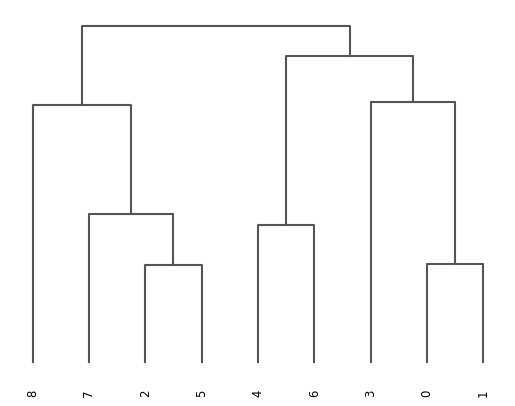

<Axes: >

In [17]:
sc.pl.dendrogram(adata, groupby='leiden')

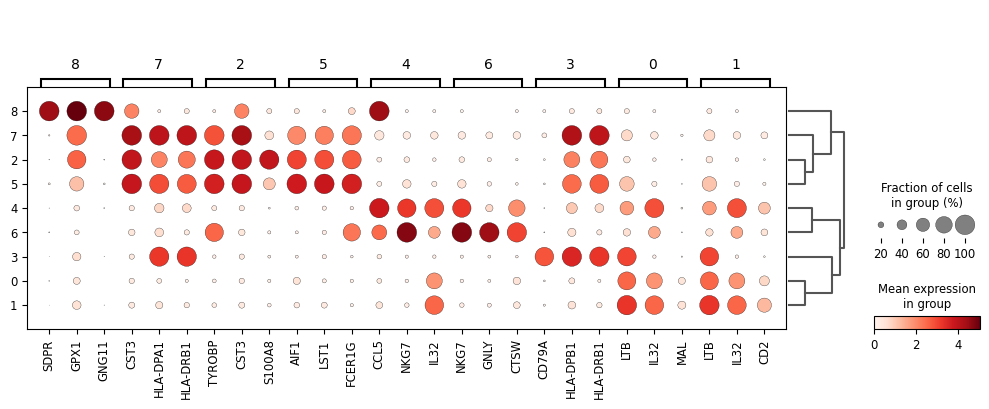

In [18]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3)